## Objective
Get threshold crossings of recording based on RMS computed over whole recording for each channel

## Setup

In [1]:
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Reload a module after changes have been made
from importlib import reload
# endregion

from spikeinterface import load_extractor
from spikeinterface.extractors import NwbRecordingExtractor, MaxwellRecordingExtractor, BinaryRecordingExtractor
from spikeinterface.toolkit.preprocessing import bandpass_filter, scale
import numpy as np
from scipy.signal import find_peaks
from tqdm import tqdm
from multiprocessing import Pool
from pathlib import Path

In [2]:
SPIKE_AMP_THRESH = 4

REC_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/sub-mouse412804_ecephys.nwb"
FREQ_MIN = 300
FREQ_MAX = 3000

In [3]:
if REC_PATH.endswith(".h5"):
    import os
    os.environ['HDF5_PLUGIN_PATH'] = '/home/mea/SpikeSorting/spikeinterface'
    
    rec = MaxwellRecordingExtractor(REC_PATH)
elif REC_PATH.endswith(".nwb"):
    rec = NwbRecordingExtractor(REC_PATH)
else:
    rec = load_extractor(REC_PATH)  # type: BinaryRecordingExtractor
fs = rec.get_sampling_frequency() / 1000

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


In [4]:
GAIN = 0.195  # rec.get_channel_gains()
OFFSET = 0  # rec.get_channel_offsets()

rec = scale(rec, GAIN, OFFSET, dtype="float32")
rec = bandpass_filter(rec, freq_min=FREQ_MIN, freq_max=FREQ_MAX, dtype="float32")

## Extract crossings - Channels
Probably faster, depends on recording format (probably faster for .nwb)

In [5]:
def thresh_crossings_channel(chan_id):
    traces = rec.get_traces(return_scaled=False, channel_ids=[chan_id]).flatten()
    rms = np.sqrt(np.mean(np.square(traces)))
    peaks = find_peaks(-traces, height=SPIKE_AMP_THRESH * rms)
    sts = peaks[0]
    heights = peaks[1]['peak_heights']
    return sts / fs, heights

thresh_crossings = []
thresh_amps = []
with Pool(processes=12) as pool:
    tasks = rec.get_channel_ids()
    for crossings, heights in tqdm(pool.imap(thresh_crossings_channel, tasks), total=len(tasks)):  # , chunksize=len(tasks)//60
        thresh_crossings.append(crossings)
        thresh_amps.append(heights)

100%|██████████| 248/248 [00:56<00:00,  4.38it/s]


In [6]:
# Sanity check that crossings on each channel are sorted
for crossings in thresh_crossings:
    assert np.all(np.diff(crossings) > 0)

## Extract RMS across entire channel

In [2]:
rec = NwbRecordingExtractor("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/sub-MEAREC-250neuron-Neuropixels_ecephys.nwb")
rec = bandpass_filter(rec, 300, 3000)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


In [3]:
def extract_rms(chan_id):
    traces = rec.get_traces(return_scaled=False, channel_ids=[chan_id]).flatten()
    rms = np.sqrt(np.mean(np.square(traces)))
    return rms

rmses = []
with Pool(processes=12) as pool:
    tasks = rec.get_channel_ids()
    for rms in tqdm(pool.imap(extract_rms, tasks), total=len(tasks)):  # , chunksize=len(tasks)//60
        rmses.append(rms)

100%|██████████| 384/384 [00:44<00:00,  8.56it/s]


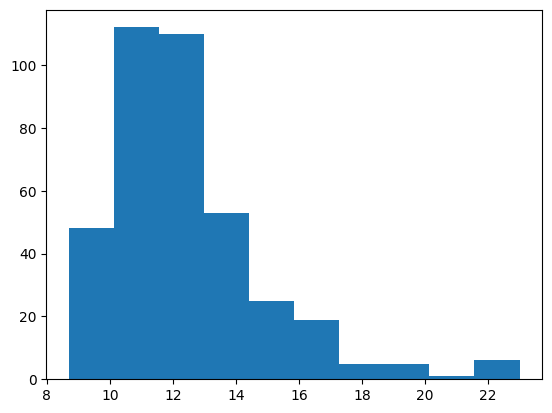

In [4]:
import matplotlib.pyplot as plt
# plt.hist(rmses, bins=50, range=(0, 40))
# plt.xlim(0, 40)
plt.hist(np.array(rmses))
plt.show()

In [26]:
# Save rms
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/chans_rms.npy", rmses)
np.save("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/chans_rms.npy", rmses)

## Extract crossings - Chunking
May be faster, depends on recording format (probably faster for .h5)

### Extract traces

In [8]:
STEP = 10000
##
traces = []
for start_frame in tqdm(range(0, rec.get_total_samples()-STEP+1, STEP)):
    traces.append(rec.get_traces(return_scaled=False, start_frame=start_frame, end_frame=start_frame+STEP))

  0%|          | 0/3600 [00:00<?, ?it/s]

  1%|▏         | 50/3600 [00:07<08:36,  6.87it/s]


KeyboardInterrupt: 

### Extract last recording chunk that may have been excluded based on STEP size

In [5]:
if start_frame + STEP < rec.get_total_samples():
    print("Getting last chunk")
    traces.append(rec.get_traces(return_scaled=False, start_frame=start_frame + STEP))

Getting last chunk


### Format traces

In [6]:
traces = np.concatenate(traces, axis=0)

In [7]:
# Double check that all recording samples were extracted only once
assert traces.size == rec.get_num_channels() * rec.get_num_samples() , "Num extracted samples does not equal num samples in recording"

### Find threshold crossings

In [8]:
thresh_crossings = []
rmses = []
for channel in tqdm(traces.T):
    rms = np.sqrt(np.mean(np.square(channel)))
    sts = find_peaks(-channel, height=SPIKE_AMP_THRESH * rms)[0]
    rmses.append(rms)
    thresh_crossings.append(sts / fs)

100%|██████████| 1020/1020 [00:25<00:00, 40.02it/s]


## Save threshold crossings

In [7]:
np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/crossings.npy", np.array(thresh_crossings, dtype=object))

In [8]:
np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/amplitudes.npy", np.array(thresh_amps, dtype=object))